# CNN on TCRs

Here I use a network doing a CNN over the input. The model architecture is a CNN of the local features. These then get pooled down to the number of channels, which is then fed into a dense layer. Difference is here that the pooling happens over the entire CNN, and not just over the individual CDRs. The hope is it chooses to remember the CDRs, which are known to be more important for binding

### Load Libraries

In [96]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, optim, cuda
from torch.utils.data.dataloader import DataLoader
from utils import Runner, EarlyStopping, TcrDataset, setup_seed
from cnn_network import TcrCNN

Set general plotting parameters for matplotlib using seaborn

In [23]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [70]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input_tcrs.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]
model_name = "tcr_model.pt"
model_path = "stored_models/"

batch_size = 64
seed= 12

setup_seed(seed)
device = torch.device("cuda" if cuda.is_available() else "cpu")
#device= torch.device("cpu")

## Define indexing

In [71]:

########### Select Indexes TCR Data ############

# Full model
# idx = np.arange(417)

# Peptide + both TCRs
idx = np.arange(179,417)

########### Select Features ###########

# All features
#local_features = np.arange(27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence
local_features = np.arange(20)
global_features = None
use_global_features = False

# Energy terms
#local_features = np.arange(20, 27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence and global energy
#local_features = np.arange(20)
#global_features = np.arange(27, 54)
#use_global_features = True


## Load Data
Partitions can be changed by altering the `data_files` and `label_files` indexing

In [72]:
train_data = TcrDataset(data_files[0], label_files[0])
train_data.add_partition(data_files[1], label_files[1])
train_data.add_partition(data_files[2], label_files[2])
val_data = TcrDataset(data_files[3], label_files[3])
test_data = TcrDataset(data_files[4], label_files[4])


# Shuffle data randomly is needed
train_data.shuffle_data()
val_data.shuffle_data()
#test_data.shuffle_data()

# slicing sequence dimension
train_data.slice_sequences(idx)
val_data.slice_sequences(idx)
test_data.slice_sequences(idx)

train_data.to_blossum()
val_data.to_blossum()
test_data.to_blossum()

input_len = train_data.data.shape[2]


In [73]:
train_dl = DataLoader(train_data, batch_size)
val_dl = DataLoader(val_data, batch_size)
test_dl = DataLoader(test_data, batch_size)

In [74]:
len(train_data), len(val_data), len(test_data)

(4174, 1532, 1207)

In [75]:
train_data.data.shape

(4174, 54, 238)

In [76]:
#Hyperparameters
epochs = 100
patience = 20
lr = 0.005
loss_weight = sum(train_data.labels) / len(train_data.labels)
weight_decay = 0.0005

# Layer parameters
cnn_channels = 3
hidden_neurons = 32
dropout = 0.4
cnn_kernel = 3

# Loss and optimizer
criterion = nn.BCELoss(reduction='none')
stopper = EarlyStopping(patience, model_name, model_path)


In [77]:
net = TcrCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
net.to(device)
print(net)
print("Using Device:", device)
optimizer = optim.Adam(net.parameters(), lr=lr,
    weight_decay=weight_decay,
    amsgrad=True
)

TcrCNN(
  (tcr_a_conv): Conv1d(20, 3, kernel_size=(3,), stride=(1,), padding=same)
  (tcr_b_conv): Conv1d(20, 3, kernel_size=(3,), stride=(1,), padding=same)
  (pep_conv): Conv1d(20, 3, kernel_size=(3,), stride=(1,), padding=same)
  (max_pool): AdaptiveMaxPool1d(output_size=1)
  (max_pool_index): AdaptiveMaxPool1d(output_size=1)
  (dense1): Linear(in_features=9, out_features=32, bias=True)
  (dense_out): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (bn_dense): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_start): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Using Device: cpu


In [78]:
# Define runners
train_runner = Runner(train_dl, net, criterion, loss_weight, device, optimizer)
val_runner = Runner(val_dl, net, criterion, loss_weight, device)
test_runner = Runner(test_dl, net, criterion, loss_weight, device)

## Training Loop

In [79]:
train_loss, val_loss, train_auc, val_auc = [], [], [], []

for epoch in range(1, epochs+1):
    train_runner.run_epoch()
    val_runner.run_epoch()
    
    train_runner.follow_performance(epoch)
    val_runner.follow_performance(epoch)
    stopper.evaluate_epoch(val_runner.loss, net, epoch)
    
    train_loss.append(train_runner.loss)
    val_loss.append(val_runner.loss)
    train_auc.append(train_runner.auc)
    val_auc.append(val_runner.auc)
    
    train_runner.reset()
    val_runner.reset()

    if stopper.stop:
        break


Epoch: 1
Train loss: 0.28860918680826825 Train MCC: 0.012150003411181075 Train AUC: 0.5037649254920418
Validation loss: 0.2586815357208252 Validation MCC: 0.10083768205214311 Validation AUC: 0.5617553690688009
Validation loss decreased. Counter reset
Epoch: 2
Train loss: 0.2668546907829516 Train MCC: 0.040724594360997145 Train AUC: 0.526312805955734
Validation loss: 0.26347702741622925 Validation MCC: 0.02738798776283828 Validation AUC: 0.6727509674663177
Early Stopping Counter: 1 out of 20
Epoch: 3
Train loss: 0.25989876371441467 Train MCC: 0.05119812243796839 Train AUC: 0.5523881400097562
Validation loss: 0.24914564689000449 Validation MCC: 0.06117943827427604 Validation AUC: 0.6997775338755234
Validation loss decreased. Counter reset
Epoch: 4
Train loss: 0.2560324524388169 Train MCC: 0.1076414490958243 Train AUC: 0.5835749418423652
Validation loss: 0.2517680327097575 Validation MCC: 0.05645714951678252 Validation AUC: 0.700366080619542
Early Stopping Counter: 1 out of 20
Epoch: 5
Tr

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

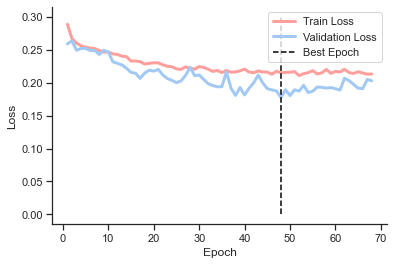

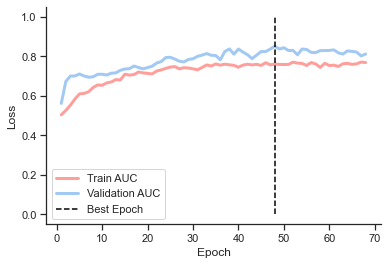

In [87]:
# Plots of training epochs
epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_loss, "r", epoch, val_loss, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=0.3, colors="black", linestyles='dashed')
plt.legend(["Train Loss", "Validation Loss", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_auc, "r", epoch, val_auc, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=1, colors="black", linestyles='dashed')
plt.legend(["Train AUC", "Validation AUC", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

## Evaluate using the best model

Best model is stored as early_stopping_state.pt and loaded into a new object

In [88]:
final_model = TcrCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
final_model.load_state_dict(torch.load(model_path + model_name))
final_model.to(device)

train_runner.model = final_model
val_runner.model = final_model
test_runner.model = final_model

In [89]:
train_runner.reset()
val_runner.reset()
test_runner.reset()

train_runner.evaluation_mode() # Set to validation to avoid more training
train_runner.run_epoch()
val_runner.run_epoch()
test_runner.run_epoch()

Evaluation on Training Data:
Loss: 0.16899575609149356
MCC: 0.5633140678609674
Confussion Matrix:
 [[2825  307]
 [ 364  678]] 

Evaluation on Validation Data:
Loss: 0.1776750683784485
MCC: 0.5084190355712321
Confussion Matrix:
 [[1014  135]
 [ 145  238]] 

Evaluation on Test Data:
Loss: 0.18256966691268117
MCC: 0.5001553432338169
Confussion Matrix:
 [[823  83]
 [132 169]] 



Text(0.5, 1.0, 'Test Data')

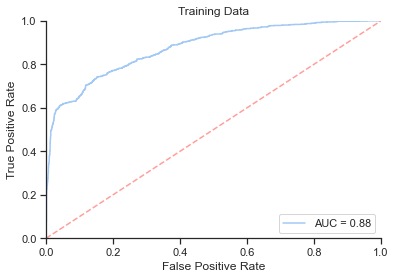

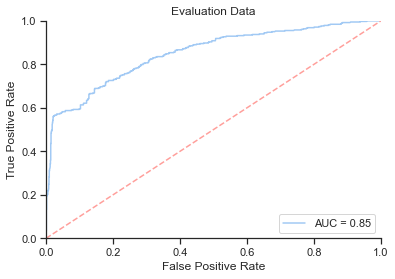

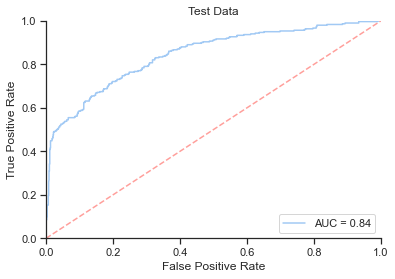

In [90]:
print("Evaluation on Training Data:")
train_runner.evaluate_model()
plt.title("Training Data")

print("Evaluation on Validation Data:")
val_runner.evaluate_model()
plt.title("Evaluation Data")

print("Evaluation on Test Data:")
test_runner.evaluate_model()
plt.title("Test Data")


## Find maxpooling positions for TCRs
First the positions from IGblast is needed for the CDR positions of each TCR

In [91]:
def parse_igblast(filename):
    """
    Parses the output from igblast and returns a dict with CDR idxs
    Key will be the query name
    """
    features = dict()
    with open(filename, "r") as fh:
        for line in fh:
            if line.startswith("# Query"):
                id = line.split()[-1]
                features[id] = dict()

            elif line.startswith("CDR1") or line.startswith("CDR2"):
                line = line.split()
                feat = line[0][:4]

                features[id][feat+"-start"] = int(line[1])
                features[id][feat+"-stop"] = int(line[2])

            elif line.startswith("FR3"):
                line = line.split()
                features[id]["CDR3-start"] = int(line[2])+1

    return features

def find_cdr3_stop(seq, feat):
    """
    Finds the missing CDR3 stop, by using that the CDR3 allways ends on either FG or WG
    and is atleast 8 amino acids long 
    """
        
    cdr3_start = feat["CDR3-start"]
    cdr3_end = seq[cdr3_start-1:].find("FG", 7)
    if cdr3_end == -1:
        cdr3_end = seq[cdr3_start-1:].find("WG", 7)

    if cdr3_end ==-1:
        print("Error in",seq[cdr3_start-1:])
    
    feat["CDR3-stop"] = cdr3_start + cdr3_end
    return feat
    
def load_sequences(file_path) -> dict:
    """
    Loads a Fasta file into a dict with header as key and sequences as values
    """
    headers = []
    sequences = []
    seq_lst = []
    with open(file_path, 'r') as fh:
        for line in fh:
            if line.startswith('>'):
                headers.append(line[1:].strip())

                if len(seq_lst) != 0:
                    sequences.append("".join(seq_lst))

                seq_lst = []

            else:
                seq_lst.append(line.strip())
    sequences.append("".join(seq_lst))

    return dict(zip(headers, sequences))

def increment_annotation_count(idx ,annotation, counter):
    """
    Find which feature the corresponding index overlaps with 
    + 1 is because sequence idx is 0 based while annotation is 1 based
    + 2 is because of a kernel size of 3 and we want all with overlap
    """
    if idx + 2 < annotation["CDR1-start"]:
        counter["FR1"] += 1
    elif idx <= annotation["CDR1-stop"] :
        counter["CDR1"] += 1   
    elif idx + 2 < annotation["CDR2-start"]:
        counter["FR2"] += 1
    elif idx <= annotation["CDR2-stop"]:
        counter["CDR2"] += 1
    elif idx + 2 < annotation["CDR3-start"]:
        counter["FR3"] += 1
    elif idx <= annotation["CDR3-stop"]:
        counter["CDR3"] += 1
    elif idx + 2  > annotation["CDR3-stop"]:
        counter["FR4"] += 1
    else:
        print("Error")
    return counter

def increase_feature_length(annotation, length_dict, seq):
    """
    Find the lengths of the 
    """
    length_dict["FR1"] += annotation["CDR1-start"] - 2
    length_dict["CDR1"] += annotation["CDR1-stop"] - annotation["CDR1-start"] + 2
    length_dict["FR2"] += annotation["CDR2-start"] - annotation["CDR1-stop"] - 2
    length_dict["CDR2"] += annotation["CDR2-stop"] - annotation["CDR2-start"] + 2
    length_dict["FR3"] += annotation["CDR3-start"] - annotation["CDR2-stop"] - 2
    length_dict["CDR3"] += annotation["CDR3-stop"] - annotation["CDR3-start"] + 2
    length_dict["FR4"] += len(seq) - annotation["CDR3-stop"] - 1
    return length_dict

In [92]:
data_dir = "../../data/"
alpha_igblast_file = data_dir + "igblast/alpha_igblast.txt"
beta_igblast_file = data_dir + "igblast/beta_igblast.txt"
alpha_seq_file = data_dir + "fasta/alpha_chains.fa"
beta_seq_file = data_dir + "fasta/beta_chains.fa"

alpha_sequences = load_sequences(alpha_seq_file)
beta_sequences = load_sequences(beta_seq_file)
alpha_igblast = parse_igblast(alpha_igblast_file)
beta_igblast = parse_igblast(beta_igblast_file)

init_model = TcrCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)

# Get indexes here
_, alpha_idxs = test_runner.get_pool_idxs("tcra")
_, beta_idxs = test_runner.get_pool_idxs("tcrb")
test_runner.model = init_model
_, alpha_idxs_init = test_runner.get_pool_idxs("tcra")
_, beta_idxs_init = test_runner.get_pool_idxs("tcrb")
test_runner.model = final_model
alpha_idxs.shape

torch.Size([3, 1207])

Calculate the number of times a filter has been chosen in the maxpooling

In [100]:
alpha_count_dict = {"FR1" : 0, "CDR1" : 0, "FR2" : 0, "CDR2" : 0, "FR3" : 0, "CDR3" : 0, "FR4" : 0}
beta_count_dict = {"FR1" : 0, "CDR1" : 0, "FR2" : 0, "CDR2" : 0, "FR3" : 0, "CDR3" : 0, "FR4" : 0}
alpha_count_dict_init = {"FR1" : 0, "CDR1" : 0, "FR2" : 0, "CDR2" : 0, "FR3" : 0, "CDR3" : 0, "FR4" : 0}
beta_count_dict_init = {"FR1" : 0, "CDR1" : 0, "FR2" : 0, "CDR2" : 0, "FR3" : 0, "CDR3" : 0, "FR4" : 0}

alpha_lengths = {"FR1" : 0, "CDR1" : 0, "FR2" : 0, "CDR2" : 0, "FR3" : 0, "CDR3" : 0, "FR4" : 0}
beta_lengths = {"FR1" : 0, "CDR1" : 0, "FR2" : 0, "CDR2" : 0, "FR3" : 0, "CDR3" : 0, "FR4" : 0}
for i in range(alpha_idxs.shape[1]): # Loop through observations
    seq_id = f"P5_tcr_seq_{i+1}"
    alpha_annotation = find_cdr3_stop(alpha_sequences[seq_id], alpha_igblast[seq_id])
    beta_annotation = find_cdr3_stop(beta_sequences[seq_id], beta_igblast[seq_id])
    for j in range(alpha_idxs.shape[0]): # Loop through filters
        alpha_count_dict = increment_annotation_count(alpha_idxs[j, i], alpha_annotation, alpha_count_dict)
        alpha_count_dict_init = increment_annotation_count(alpha_idxs_init[j, i], alpha_annotation, alpha_count_dict_init)
        alpha_lengths = increase_feature_length(alpha_annotation, alpha_lengths, alpha_sequences[seq_id])

    for j in range(beta_idxs.shape[0]): # Loop through filters
        beta_count_dict = increment_annotation_count(beta_idxs[j, i], beta_annotation, beta_count_dict)
        beta_count_dict_init = increment_annotation_count(beta_idxs_init[j, i], beta_annotation, beta_count_dict_init)
        beta_lengths = increase_feature_length(beta_annotation, beta_lengths, beta_sequences[seq_id])

for feat in alpha_count_dict:
    alpha_lengths[feat] = alpha_lengths[feat] / (alpha_idxs.shape[0] * alpha_idxs.shape[1])
    beta_lengths[feat] = beta_lengths[feat] / (beta_idxs.shape[0] * beta_idxs.shape[1])

    alpha_count_dict[feat] = alpha_count_dict[feat] / alpha_lengths[feat]
    beta_count_dict[feat] = beta_count_dict[feat] / beta_lengths[feat] 
    alpha_count_dict_init[feat] = alpha_count_dict_init[feat] / alpha_lengths[feat]
    beta_count_dict_init[feat] = beta_count_dict_init[feat] / beta_lengths[feat] 

Text(0.5, 1.0, 'Maxpooling filter positions over entire Beta chain')

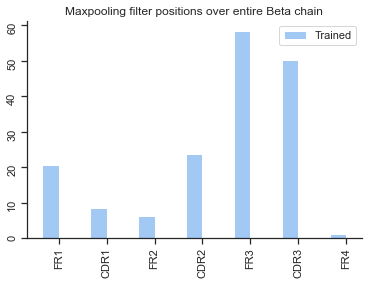

In [101]:
width = 0.35

fig, ax = plt.subplots()
x = np.arange(len(beta_count_dict.keys()))

rects1 = ax.bar(x - width/2, beta_count_dict.values() , width, label='Trained')
ax.tick_params(rotation=90)
ax.set_xticks(x, beta_count_dict.keys())
ax.legend()
ax.set_title(f"Maxpooling filter positions over entire Beta chain")

Text(0.5, 1.0, 'Maxpooling filter positions over entire Beta chain')

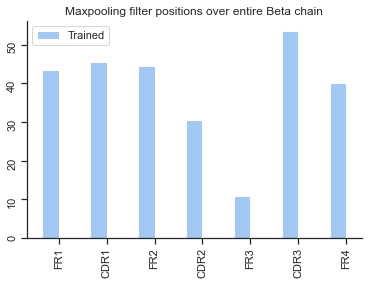

In [102]:
width = 0.35

fig, ax = plt.subplots()
x = np.arange(len(alpha_count_dict.keys()))

rects1 = ax.bar(x - width/2, alpha_count_dict.values() , width, label='Trained')
ax.tick_params(rotation=90)
ax.set_xticks(x, alpha_count_dict.keys())
ax.legend()
ax.set_title(f"Maxpooling filter positions over entire Beta chain")